
# Industry Accelerators - Insurance Loss Estimation Using Remote Sensing Data

## Impact Region Analysis with Remote Sensing

### Contents
- [Introduction](#intro)
- [Libraries](#library)
- [Query Raw Images](#queryRaw)
- [Compute Event-Related Metrics](#metrics)
- [Compute Event Impact Score](#impactscore)
- [Identify Highly-Impacted Regions](#highimpact)
- [Compute Spatial Index](#spatialindex)

## Introduction <a name="intro"></a>

In this notebook, we will go through the end to end process of how to derive insights on a flooding area by utilizing an example of flooding events to assist insurance claims. The idea of this notebook is to study satellite images before and after a certain event (e.g. hurricane Laura), and with the help of spatiotemporal analysis and ML/AI techniques, we can get insights like which regions are affected and to what extent. Such insights provide valuable information to insurance companies for better assessing property damages thus better deal with damage claims in a more efficient and effective way.





Before executing this notebook on IBM Cloud , you need to:<br>
1) When you import this project on an IBM Cloud environment, insert a project access token at the top of this notebook as a code cell. <br>
If you do not see the cell above, Insert a project token: Click on **More -> Insert project token** in the top-right menu section and run the cell <br>

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)
2) You can then step through the notebook execution cell by cell, by selecting Shift-Enter. You can also execute the entire notebook by selecting **Cell -> Run All** from the menu.<br>



In [2]:
try:
    project
except NameError:
    # READING AND WRITING PROJECT ASSETS
    import project_lib
    project = project_lib.Project() 

## Prepare libraries <a name="library"></a>

There are two major dependencies in this notebook:

1. Pyrip - a GDAL-based Raster Image Processor
    - Query raster data from COS in a cloud native way
    - Merge and compute basic metrics from multiple raster layers
    - Convert raster data to vector data
2. pyst - Spatiotemporal toolkit in CP4D/WS
    - Spatial filtering on vector data
    - Compute convex hull from spatial points
    - Visualize spatial objects on basemap
    - Export spatial results to common formats like geojson, spatial dataframe, etc.
    - Create spatial index to efficiently index spatial objects, such as finding the nearest objects from the given location.

The cell below installs the `pyrip` library together with its dependency `gdal` and imports the libraries that we will use throughout the notebook.

In [3]:
#%%capture
! conda install -c conda-forge gdal
! pip install pyrip
! ln -s /usr/lib64/libnsl.so.2 /home/spark/shared/conda/envs/python/lib/libnsl.so.1

Solving environment: done

## Package Plan ##

  environment location: /home/spark/shared/conda/envs/python

  added / updated specs:
    - gdal


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            1_gnu          22 KB  conda-forge
    boost-cpp-1.74.0           |       h312852a_4        16.3 MB  conda-forge
    bzip2-1.0.8                |       h7f98852_4         484 KB  conda-forge
    c-ares-1.17.1              |       h7f98852_1         109 KB  conda-forge
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    cairo-1.16.0               |    h6cf1ce9_1008         1.5 MB  conda-forge
    certifi-2020.12.5          |   py37h89c1867_1         143 KB  conda-forge
    cfitsio-3.470              |       hb418390_7         1.3 MB  conda-forge
    cur

libnghttp2-1.43.0    | 808 KB    | ##################################### | 100% 
sqlite-3.35.5        | 1.4 MB    | ##################################### | 100% 
certifi-2020.12.5    | 143 KB    | ##################################### | 100% 
xorg-libxau-1.0.9    | 13 KB     | ##################################### | 100% 
pthread-stubs-0.4    | 5 KB      | ##################################### | 100% 
libgomp-9.3.0        | 376 KB    | ##################################### | 100% 
libkml-1.3.0         | 590 KB    | ##################################### | 100% 
libspatialite-5.0.1  | 4.4 MB    | ##################################### | 100% 
geos-3.9.1           | 1.1 MB    | ##################################### | 100% 
libtiff-4.3.0        | 668 KB    | ##################################### | 100% 
cfitsio-3.470        | 1.3 MB    | ##################################### | 100% 
geotiff-1.6.0        | 296 KB    | ##################################### | 100% 
tzcode-2021a         | 68 KB

     |████████████████████████████████| 147 kB 47.8 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 1.2 MB/s  eta 0:00:01
     |████████████████████████████████| 227 kB 50.1 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 46.8 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 4.0 MB/s  eta 0:00:01
ERROR: conda 4.8.2 requires ruamel_yaml>=0.11.14, which is not installed.
ERROR: tensorflow 2.1.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.5.0 which is incompatible.
ERROR: ibm-watson-machine-learning 1.0.38 has requirement pandas<=1.0.5, but you'll have pandas 1.2.4 which is incompatible.


In [4]:
import os
libs = os.environ['LD_LIBRARY_PATH']
%env LD_LIBRARY_PATH=$libs:/home/spark/shared/conda/envs/python/lib/

%matplotlib inline

import datetime
import branca

from pyrip.cog import query_polygon
from pyrip.image import get_shape
from pyrip.transform import tif_to_numpy, tif_to_df
from pyrip.plot import plot
from pyrip.calc import calculate

from pyst import STContext
stc = STContext(spark.sparkContext._gateway)

from sklearn.cluster import DBSCAN
import numpy as np

import pandas as pd



env: LD_LIBRARY_PATH=/opt/ibm/connectors/dsdriver/dsdriver/lib:/opt/ibm/connectors/others-db-drivers/oracle/lib:/opt/ibm/jdk/jre/lib/architecture/server:/opt/ibm/jdk/jre/lib/architecture/:/usr/local/lib:/lib64:/home/spark/shared/conda/envs/python/lib/


## Step 1: Query Raw Images <a name="queryRaw"></a>

This section provides a template of querying raw data from cloud in an optimized and generalizable way, as raw data is typically large in volume and sits in cloud. 
In this accelerator, we query images for the area of Cameron, Louisiana, before and after hurricane Laura. 

**Since we already generated the output of this step and stored in data assets you can skip running this section and start with step 2 directly. If you want to analyze a different region for a different period of time then include inputs below and run the cells.**

The first step of analyzing remote sensing data is to query (i.e. pull) the data of interest. The volume of remote sensing can be extremely large, so being able to query the exact data you need (e.g. pull a small neighborhood during a couple days' period from a 10 years worth of global data) in a cost-efficient and time-efficient way is crucial. We utilize the cloud native way by implementing cloud-optimized raster data on native cloud storage, which is extremely fast and cost-efficient. 


We can query an arbitrary region with our cloud-optimized query functions:
- `query`: query a bbox
- `query_radius`: query a circle (point-with-radius)
- `query_polygon`: query an arbitrary polygon in wkt format


1. Specify the credentials for the COS bucket that stores the remote sensing data

In [5]:
access_key_id = 'xxx'
secret_access_key = 'xxx'
endpoint_url = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'
endpoint = endpoint_url.replace('https://', '')

2. Specify the area of interest. Here we use a polygon.

In [6]:
cameron_polygon = 'POLYGON((-93.34231356979647 29.801644120752755,-93.32600573898593 29.79724972298948,-93.32608192997783 29.79639943818124,-93.32312077122539 29.794034556357637,-93.32202497088649 29.79096167328499,-93.3270889815066 29.784630024109077,-93.32657399737575 29.779415424066013,-93.33790364825465 29.779415424066013,-93.34108813699372 29.77461816082034,-93.34177478250153 29.76437391510573,-93.29300322900527 29.776909954345403,-93.23353082746084 29.780434142575885,-93.23387415021475 29.797268702758736,-93.34231356979647 29.801644120752755))'

3. Specify local file names. In this case, we will download two bands (B03 for band Green and B08 for band Near-Infrared) before and after the event, and compute a derived layer ([NDWI](https://en.wikipedia.org/wiki/Normalized_difference_water_index)) before and after the event.

In [7]:
b03_before = 'b03_before.tif'
b03_after = 'b03_after.tif'
b08_before = 'b08_before.tif'
b08_after = 'b08_after.tif'
ndwi_before = 'ndwi_before.tif'
ndwi_after = 'ndwi_after.tif'
ndwi_change = 'ndwi_change.tif'

4. Run a cloud native query to retrieve remote sensing data only for the area of interest.

**This is where the cloud-native optimization comes into place. Here we query a small sample file from the underlying tens of TBs worth of files, thus achieving sub-second performance per query. Uncomment the cell to run.**

In [8]:

# query_polygon('cos-url-here', b03_before, cameron_polygon, access_key_id=access_key_id, secret_access_key=secret_access_key, endpoint=endpoint)
# query_polygon('cos-url-here', b03_after, cameron_polygon, access_key_id=access_key_id, secret_access_key=secret_access_key, endpoint=endpoint)
# query_polygon('cos-url-here', b08_before, cameron_polygon, access_key_id=access_key_id, secret_access_key=secret_access_key, endpoint=endpoint)
# query_polygon('cos-url-here', b08_after, cameron_polygon, access_key_id=access_key_id, secret_access_key=secret_access_key, endpoint=endpoint)


## Step 2: Compute Event-Related Metrics from Raw Images, Before and After the Event <a name="metrics"></a>

The second step is to derive some metrics from the raw images.

Once we've pulled the raw images, we are interested in computing various topic-related metrics. You can use our `calculate(inputs, output, lambda_fn)` to easily apply any lambda function you need to your input images.

In this case, we are interested in identifying flooding areas in Cameron due to hurricane Laura. Therefore, we compute the NDWI (Normalized Difference Water Index) layer from raw images, as flooding area after the hurricane will have a higher NDWI value.

The NDWI is defined by: `(Green - NIR)` / `(Green + NIR)`, and we apply this formula to both before-event images and after-event images:

*Note that you can apply any formula here that is numpy-evaluable, so this function gives you the power to process the images in all sorts of lambda expressions you need.*

In [9]:
# Read queried raw data. 
# This is the output from previous step 1, and we are providing this output with the demo so you don't need to setup COS and upload your own data.
b03_before = 'b03_before.tif'
b03_after = 'b03_after.tif'
b08_before = 'b08_before.tif'
b08_after = 'b08_after.tif'

with open(b03_before, 'wb') as outfile:
    outfile.write(project.get_file('b03_before.tif').getbuffer())
with open(b03_after, 'wb') as outfile:
    outfile.write(project.get_file('b03_after.tif').getbuffer())
with open(b08_before, 'wb') as outfile:
    outfile.write(project.get_file('b08_before.tif').getbuffer())
with open(b08_after, 'wb') as outfile:
    outfile.write(project.get_file('b08_after.tif').getbuffer())

# specify names of generated files
ndwi_before = 'ndwi_before.tif'
ndwi_after = 'ndwi_after.tif'
ndwi_change = 'ndwi_change.tif'

In [10]:
calculate([b03_before, b08_before], ndwi_before, '(A.astype("float32")-B.astype("float32"))/(A.astype("float32")+B.astype("float32"))', dtype='Float32')
calculate([b03_after, b08_after], ndwi_after, '(A.astype("float32")-B.astype("float32"))/(A.astype("float32")+B.astype("float32"))', dtype='Float32')

'ndwi_after.tif'

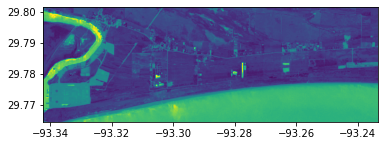

In [11]:
plot(ndwi_before)

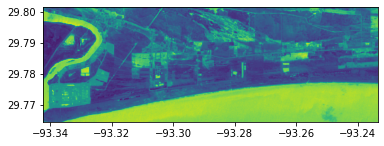

In [12]:
plot(ndwi_after)

## Step 3: Compute Event Impact Score <a name="impactscore"></a>

Now let's continue with some metrics computation.

In this case, our score is defined by `water_index_after_event` - `water_index_before_event`, i.e. change of water index after the hurricane, which only computed on areas that has low water index before the event and high water index after the event.

Similar to the previous step, we leverage the same function `calculate` to apply our lambda expression:

In [13]:
calculate([ndwi_before, ndwi_after], ndwi_change, '(B-A)*logical_and(A<0, B>0.1)')

'ndwi_change.tif'

This image is a grey-scaled image that captures NDWI changes. Brighter colors indicate higher changes of water index, which further indicate that flooding happened. As we can see, the brighter color forms several clusters. These are the regions that got flooded due to hurricane.

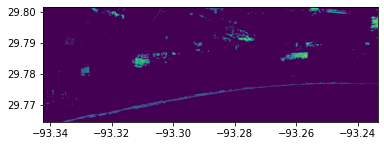

In [14]:
plot(ndwi_change)

## Step 4: Identify Highly-Impacted Regions with Scores <a name="highimpact"></a>

### Step 4.1: Convert Scoring Result from Raster Image to Vector Data

So far, we have done our computations and scorings based on raster data. However, such raster format is not analysis-ready. We want to have it in vector format (e.g. a pandas dataframe and a numpy array) which is better for further ML/AI analysis. Thus we convert the raster result to a vector form, by converting it to a pandas dataframe and preserving regions that we are interested in (i.e. regions with a change in water index)

In [15]:
df = tif_to_df(ndwi_change)
df = df[df['value']>0]
df.head(3)

,lat,lon,value
147,29.801662,-93.327965,0.642590
148,29.801662,-93.327868,0.622829
269,29.801662,-93.316085,0.752158


### Step 4.2: Spatial Filtering with Waton Studio Spatiotempral Toolkit

The images we pulled and computed are actually the bounding box of the cameron polygon (i.e. contain more data than we want), which is unavoidable in raster form as images always have the shape of a box. Now we have converted it to a vector form, so we can apply our spatial filter to get data precisely into our polygon.

In [16]:
cameron_polygon = 'POLYGON((-93.34231356979647 29.801644120752755,-93.32600573898593 29.79724972298948,-93.32608192997783 29.79639943818124,-93.32312077122539 29.794034556357637,-93.32202497088649 29.79096167328499,-93.3270889815066 29.784630024109077,-93.32657399737575 29.779415424066013,-93.33790364825465 29.779415424066013,-93.34108813699372 29.77461816082034,-93.34177478250153 29.76437391510573,-93.29300322900527 29.776909954345403,-93.23353082746084 29.780434142575885,-93.23387415021475 29.797268702758736,-93.34231356979647 29.801644120752755))'
cameron = stc.wkt_reader().read(cameron_polygon)
def f(lat, lon):
    return cameron.contains(stc.point(lat, lon))

df['in_cameron'] = df.apply(lambda row: f(row['lat'], row['lon']), axis=1)
df = df[df['in_cameron']]

### Step 4.3: Spatial Clustering

Now we have all the point locations that are highly-impacted by the flooding issue, next step is to cluster these points to a set of clusters (i.e. regions).

In this case, we leverage the DBSCAN clustering Algorithm to cluster the points.

In [17]:
clusters = DBSCAN(eps=0.02/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(df[['lat', 'lon']].values))
df['cluster'] = clusters.labels_ 
df.head(5)

,lat,lon,value,in_cameron,cluster
7985,29.80098,-93.326115,0.693647,True,0
7986,29.80098,-93.326018,0.700475,True,0
7987,29.80098,-93.325920,0.735671,True,0
7988,29.80098,-93.325823,0.758209,True,0
7989,29.80098,-93.325726,0.784354,True,0


In [18]:
cluster_size = df.groupby('cluster').size()
min_cluster_size = 100
target_clusters = cluster_size[cluster_size >= min_cluster_size].index.tolist()
try:
    target_clusters.remove(-1)
except ValueError:
    pass

### Step 4.4: Compute Convex Hull from Clusters

With a set of clusters of points, we can now form the regions. We do this by computing the convex hull of each cluster.

In [19]:
hulls = []
props = []
for target_cluster in target_clusters:
    tmp_df = df[df['cluster']==target_cluster]
    points = []
    for row in tmp_df.itertuples():
        points.append(stc.point(row.lat, row.lon))
    hull = stc.convex_hull.compute_convex_hull(points)
    hulls.append(hull)
    props.append((tmp_df['value'].mean(), tmp_df['value'].quantile(0.1), tmp_df['value'].quantile(0.9), hull.area()))

### Step 4.5: Visualize Highly-Impacted Regions

Let's visualize the computed regions that are highly impacted by the event, here the darker the color, the higher the impact score

In [20]:
scores = [prop[0] for prop in props]
colorscale = branca.colormap.linear.Reds_03.scale(min(scores), max(scores))
for idx, hull in enumerate(hulls):
    if idx == 0:
        m = stc.generate_map(hull, color=colorscale(scores[idx]), fill=True, popup='score: {}, min_score: {}, max_score: {}, area: {}'.format(*props[idx]))
    else:
        m = stc.generate_map(hull, m, color=colorscale(scores[idx]), fill=True, popup='score: {}, min_score: {}, max_score: {}, area: {}'.format(*props[idx]))
m

## Step 5. Spatial Index <a name="spatialindex"></a>

Now that we have enough information about the event impact (the boundary of impacted area along with the impact score), we can perform customer profiling by leveraging the spatial index to calculate if and how much each customer's property gets affected. This is the business insight we want to gain from this demo.

### Step 5.1 Get Property Locations

Here we read in property locations.

In [21]:
properties = pd.read_csv(project.get_file('Remote Sensing Input.csv'))
properties.head(3)

,PropertyId,lat,lon
0,1001,29.80098,-93.326115
1,1002,29.80098,-93.326018
2,1003,29.80098,-93.325920


### Step 5.2 Create In-Memory Spatial Index for Impacted Regions

We create an in-memory spatial index, and push the boundaries of all impacted areas to the index, which allows us to index any given location on whether or not the location is within any of these impacted areas.

In [22]:
index = stc.tessellation_index(bbox=cameron.get_bounding_box(), tile_size=100)

In [23]:
for idx, hull in enumerate(hulls):
    index.put(hull, 'zone_{}-{}'.format(idx, '-'.join(map(str, props[idx]))))

### Step 5.3 Index Property Locations and Augment Impact Info ①

We profile each property location by augmenting properties within any impacted region, along with the region id and impact score.

In [24]:
# Based on your application, you might want to normalize your metrics to clip your normalized score within a certain range, e.g. 0 to 1.
MIN_CHANGE_SCORE = 0.3
MAX_CHANGE_SCORE = 1.1
def norm_score(v):
    return (v - MIN_CHANGE_SCORE) / (MAX_CHANGE_SCORE - MIN_CHANGE_SCORE)

In [25]:
def f2(lat, lon):
    res = index.containing(stc.point(lat, lon))
    if len(res) == 0:
        return pd.Series([False, None, 0, 0, 0])
    else:
        return pd.Series([True, 
                          res[0].split('-')[0],
                          norm_score(float(res[0].split('-')[1])), 
                          norm_score(float(res[0].split('-')[2])), 
                          norm_score(float(res[0].split('-')[3]))])

In [26]:
properties[['within_impacted_zones', 'Impact_Zone', 'Impact_Score', 'Impact_Score_min', 'Impact_Score_max']] = properties.apply(lambda row: f2(row['lat'], row['lon']), axis=1)

In [27]:
properties.sort_values('Impact_Score', ascending=False).head(6)

,PropertyId,lat,lon,within_impacted_zones,Impact_Zone,Impact_Score,Impact_Score_min,Impact_Score_max
1891,2892,29.791145,-93.276937,True,zone_2,0.691814,0.595193,0.785853
1812,2813,29.791339,-93.274698,True,zone_2,0.691814,0.595193,0.785853
1835,2836,29.791242,-93.277911,True,zone_2,0.691814,0.595193,0.785853
1834,2835,29.791242,-93.278009,True,zone_2,0.691814,0.595193,0.785853
1833,2834,29.791242,-93.278106,True,zone_2,0.691814,0.595193,0.785853
1832,2833,29.791242,-93.278203,True,zone_2,0.691814,0.595193,0.785853


### Step 5.4 Index Property Locations and Augment Impact Info ②

In the example above, we categorized each property into either impacted or non-impacted. However, for the non-impacted properties, we might be also interested in how far away from the nearest impacted region they are, which can help the business decide if an alarm should be raised for these customers.

In [28]:
def f3(lat, lon):
    res = index.nearest_neighbors_with_info(stc.point(lat, lon), 1)[0]
    return pd.Series([res[0].split('-')[0], 
                      norm_score(float(res[0].split('-')[1])), 
                      norm_score(float(res[0].split('-')[2])), 
                      norm_score(float(res[0].split('-')[3])),
                      res[2]])

In [29]:
properties[['Nearest_Impacted_Zone', 'Nearest_Impacted_Zone_Score', 'Nearest_Impacted_Score_min', 'Nearest_Impacted_Score_max', 'Distance_to_Nearest_Impact_Zone']] = properties.apply(lambda row: f3(row['lat'], row['lon']), axis=1)

In [30]:
properties.head(3)

,PropertyId,lat,lon,within_impacted_zones,Impact_Zone,Impact_Score,Impact_Score_min,Impact_Score_max,Nearest_Impacted_Zone,Nearest_Impacted_Zone_Score,Nearest_Impacted_Score_min,Nearest_Impacted_Score_max,Distance_to_Nearest_Impact_Zone
0,1001,29.80098,-93.326115,False,None,0.0,0.0,0.0,zone_0,0.625708,0.54962,0.700211,593.220841
1,1002,29.80098,-93.326018,False,None,0.0,0.0,0.0,zone_0,0.625708,0.54962,0.700211,583.974036
2,1003,29.80098,-93.325920,False,None,0.0,0.0,0.0,zone_0,0.625708,0.54962,0.700211,574.733403


### Step 5.4:  Save out the Result
The results above will be saved in the data assets using project_lib. In our next notebook `2 - Model Training and Deployment`, this result will be used to predict Estimated Claim Amount on the individual properties.

In [31]:
project.save_data('Remote Sensing Output.csv', properties.to_csv(index=False), overwrite=True)

{'file_name': 'Remote Sensing Output.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'insurancelossestimationusingremot-donotdelete-pr-tex9yjwvam6vkk',
 'asset_id': '72bb72ae-9db7-4cff-897c-394d66678c1b'}

<hr>

Sample Materials, provided under <a href="https://github.com/IBM/Industry-Accelerators/blob/master/CPD%20SaaS/LICENSE" target="_blank" rel="noopener noreferrer">license</a>. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020, 2021. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>